In [2]:
import numpy as np
import pandas as pd
import torch
import torch.utils.data as td
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import matplotlib.colors as colors

froot = './data/k562_small'

df = pd.read_csv(froot + ".csv")

In [3]:
print(df.head())

   seqnames     start       end strand  ensembl_gene_id  score      ctcf  \
0         6  41077441  41077441      +  ENSG00000001167    0.0 -0.074159   
1         6  41077442  41077442      +  ENSG00000001167    0.0 -0.074217   
2         6  41077443  41077443      +  ENSG00000001167    0.0 -0.074276   
3         6  41077444  41077444      +  ENSG00000001167    0.0 -0.074336   
4         6  41077445  41077445      +  ENSG00000001167    0.0 -0.074398   

   h3k36me3   h3k4me1  h3k79me2  ...       sj3       dms      rpts  wgbs  \
0 -0.347414 -0.231637  1.630302  ... -0.057178 -0.307549  0.249626   0.0   
1 -0.346807 -0.231970  1.628545  ... -0.057178 -0.307549  0.249626   0.0   
2 -0.346199 -0.232304  1.626748  ... -0.057178 -0.307549  0.249626   0.0   
3 -0.345591 -0.232638  1.624913  ... -0.057178 -0.307549  0.249626   0.0   
4 -0.344983 -0.232972  1.623041  ... -0.057178 -0.307549  0.249626   0.0   

       A         T         G         C  lambda_alphaj      zeta  
0 -0.625  1.473964 -

In [4]:
df['gene_length'] = df.groupby('ensembl_gene_id')['ensembl_gene_id'].transform('count')

In [5]:
column_names = df.columns.tolist()
feature_names = column_names[6:-7]
nucleotides = column_names[-7:-3]
print(feature_names)
print(nucleotides)

# process read counts
X_ji = df.groupby('ensembl_gene_id')['score'].apply(list).tolist() 

# process GLM simulated elongation rates
Z_ji = df.groupby('ensembl_gene_id')['zeta'].apply(list).tolist() 

num_samples = len(X_ji)

['ctcf', 'h3k36me3', 'h3k4me1', 'h3k79me2', 'h3k9me1', 'h3k9me3', 'h4k20me1', 'sj5', 'sj3', 'dms', 'rpts', 'wgbs']
['A', 'T', 'G', 'C']


In [6]:
from sklearn.preprocessing import MinMaxScaler

#Y_ji is a list of samples containing lists of their feature values
    # [   
    #   [[sample_1_feature_1], [sample_1_feature_2], [sample_1_feature_3]],
    #   [[sample_2_feature_1], [sample_1_feature_2], [sample_1_feature_3]],  
    # ]

Y_ji = []

for sample_id in df['ensembl_gene_id'].unique():
    sample_data = [df[feature_name][df['ensembl_gene_id'] == sample_id].tolist() for feature_name in feature_names]
    Y_ji.append(sample_data)

In [7]:
# normalize features
scaler = MinMaxScaler()
Y_ji = np.array(Y_ji)
# reshape dataset to [num_samples, num_features * feature_length]
Y_ji_reshaped = Y_ji.reshape(Y_ji.shape[0], -1)
normalized_Y_ji_reshaped = scaler.fit_transform(Y_ji_reshaped)
Y_ji = normalized_Y_ji_reshaped.reshape(Y_ji.shape)

In [8]:
C_j = df.groupby('ensembl_gene_id')['lambda_alphaj'].apply(list).tolist() 

In [9]:
from torch.utils.data import Dataset, DataLoader, TensorDataset

class CustomDataset(Dataset):
    def __init__(self, Y_ji, X_ji, C_j, Z_ji):
        self.Y_ji = Y_ji
        self.X_ji = X_ji
        self.C_j = C_j
        self.Z_ji = Z_ji

    def __len__(self):
        return len(self.X_ji)

    def __getitem__(self, idx):
        return {
            'Y_ji':  torch.tensor(self.Y_ji[idx], dtype=torch.float32),
            'X_ji': torch.tensor(self.X_ji[idx], dtype=torch.float32),
            'C_j': torch.tensor(self.C_j[idx], dtype=torch.float32),
            'Z_ji': torch.tensor(self.Z_ji[idx], dtype=torch.float32)
        }

In [10]:
dataset = CustomDataset(Y_ji, X_ji, C_j, Z_ji)

trnset, valset, tstset = td.random_split(dataset, [0.5,0.25,0.25])

trndl = DataLoader(trnset, batch_size=64, shuffle=True)
tstdl = DataLoader(tstset, batch_size=64, shuffle=False)
valdl = DataLoader(valset, batch_size=64, shuffle=False)

Model(
  (lstm_layers): ModuleList(
    (0): LSTM(200, 64, batch_first=True)
    (1-4): 4 x LSTM(64, 64, batch_first=True)
  )
  (layer_norms): ModuleList(
    (0-4): 5 x LayerNorm((64,), eps=1e-05, elementwise_affine=True)
  )
  (fc): Linear(in_features=64, out_features=200, bias=True)
)
torch.Size([64, 200])
Number of parameters: 214856


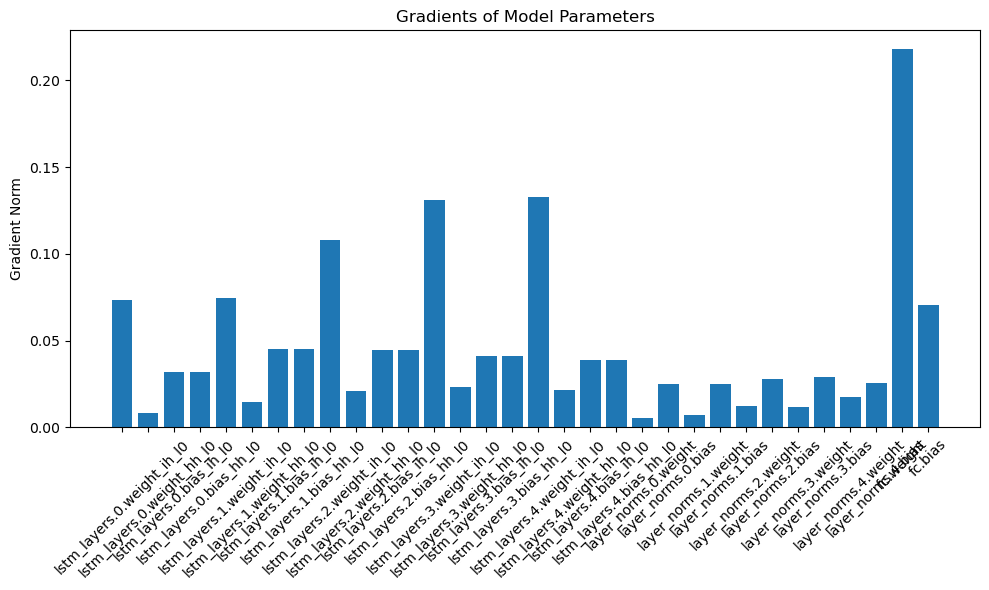

In [11]:
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.nn.init as init

class Model(nn.Module):
    def __init__(self, input_size, hidden_size, num_lstm_layers):
        super(Model, self).__init__()
        self.hidden_size = hidden_size
        self.lstm_layers = nn.ModuleList([nn.LSTM(input_size=input_size if i == 0 else hidden_size,
                                                  hidden_size=hidden_size,
                                                  num_layers=1,  # Use single-layer LSTMs in the stack
                                                  batch_first=True) for i in range(num_lstm_layers)])
    
        self.layer_norms = nn.ModuleList([nn.LayerNorm(hidden_size) for _ in range(num_lstm_layers)])
    
        for lstm_layer in self.lstm_layers:
            # Apply Xavier initialization to LSTM weights
            for param in lstm_layer.parameters():
                if len(param.shape) >= 2:
                    init.xavier_uniform_(param)

        self.fc = nn.Linear(hidden_size, input_size)
        init.xavier_uniform_(self.fc.weight)
    
    def forward(self, x):
        for i, lstm_layer in enumerate(self.lstm_layers):
            x, _ = lstm_layer(x)
            x = self.layer_norms[i](x)
        averaged_outputs = torch.mean(x, dim=1)
        hidden_outputs = F.relu(averaged_outputs) 
        predictions = self.fc(hidden_outputs)
        return predictions

# input size: [50, 12, 2000]
input_size = 200
hidden_size = 64
num_lstm_layers = 5

model = Model(input_size, hidden_size, num_lstm_layers)
print(model)

arr = torch.randn((64,12,200))
print(model(arr).shape)
nparm = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Number of parameters: " + str(nparm))

output = model(arr)

# Compute gradients
output.mean().backward()

# Plot gradients
gradient_list = []
parameter_names = []

for name, param in model.named_parameters():
    if param.grad is not None:
        gradient_list.append(param.grad.norm().item())
        parameter_names.append(name)

plt.figure(figsize=(10, 6))
plt.bar(parameter_names, gradient_list)
plt.ylabel('Gradient Norm')
plt.title('Gradients of Model Parameters')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [15]:
class CustomLoss(nn.Module):
    def __init__(self):
        super(CustomLoss, self).__init__()

    def forward(self, X_ji, C_j, Z_ji):
        epsilon = 1e-8
        clipped_Z_ji = torch.clamp(Z_ji, epsilon)
        loss = X_ji * torch.log(clipped_Z_ji) + C_j * torch.exp(-clipped_Z_ji)
        loss_2 = Z_ji
        # compute mean over batch to normalize due to varying batch sizes
        return loss.mean()#nn.MSELoss()(loss_1, loss_2)#loss.mean() 

In [13]:
def plot_data(targets, outputs):
    indices = range(len(targets[0]))

    fig, axs = plt.subplots(3, 3, figsize=(15,15))
    for i in range(3):
        for j in range(3):
            axs[i, j].scatter(indices, targets[i+j*3], s=5)
            axs[i, j].scatter(indices, outputs.detach().numpy()[i+j*3], s=5)
            axs[i, j].set_ylim(0.4, 1.3)

    plt.xlabel('Index')
    plt.ylabel('Elongation Rates')
    plt.legend(['GLM Elongation Rate', 'NN Elongation Rate'], loc='upper center', bbox_to_anchor=(0.5, -0.6))


In [16]:
import torch.optim.lr_scheduler as lr_scheduler

optimizer = optim.Adam(model.parameters(), lr=0.001)

scheduler = lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)


num_epochs = 50

loss_hist_train = [0] * num_epochs
loss_hist_valid = [0] * num_epochs

loss_fn = CustomLoss()#nn.L1Loss()#nn.MSELoss()#CustomLoss()

for epoch in range(num_epochs):
    print(f'Epoch {epoch+1}')
    model.train()
    for batch in trndl:
        optimizer.zero_grad()
        Y_ji_batch = batch['Y_ji']
        X_ji_batch = batch['X_ji']
        C_j_batch = batch['C_j']
        outputs = model(Y_ji_batch)
        loss = loss_fn(X_ji_batch, C_j_batch, outputs)
        #loss = loss_fn(batch['Z_ji'], outputs)
        loss.backward()
        optimizer.step()
        loss_hist_train[epoch] += loss.item()
        #if epoch == 49:
         #   plot_data(batch['Z_ji'], outputs)
    loss_hist_train[epoch] /= len(trndl.dataset)
    scheduler.step()
    
    model.eval()
    with torch.no_grad():
        for batch in valdl:
            Y_ji_batch = batch['Y_ji']
            X_ji_batch = batch['X_ji']
            C_j_batch = batch['C_j']
            outputs = model(Y_ji_batch)
            loss = loss_fn(X_ji_batch, C_j_batch, outputs)
            #loss = loss_fn(batch['Z_ji'], outputs)
            loss_hist_valid[epoch] += loss.item()
        loss_hist_valid[epoch] /= len(valdl.dataset)
    
    print(f'Epoch {epoch+1} trn_loss: '
          f'{loss_hist_train[epoch]:.4f} val_loss: '
          f'{loss_hist_valid[epoch]:.4f}')

Epoch 1
Epoch 1 trn_loss: -0.0046 val_loss: -0.0052
Epoch 2
Epoch 2 trn_loss: -0.0060 val_loss: -0.0062
Epoch 3
Epoch 3 trn_loss: -0.0069 val_loss: -0.0071
Epoch 4
Epoch 4 trn_loss: -0.0075 val_loss: -0.0073
Epoch 5
Epoch 5 trn_loss: -0.0076 val_loss: -0.0073
Epoch 6
Epoch 6 trn_loss: -0.0077 val_loss: -0.0073
Epoch 7
Epoch 7 trn_loss: -0.0076 val_loss: -0.0074
Epoch 8
Epoch 8 trn_loss: -0.0077 val_loss: -0.0074
Epoch 9
Epoch 9 trn_loss: -0.0077 val_loss: -0.0074
Epoch 10
Epoch 10 trn_loss: -0.0077 val_loss: -0.0074
Epoch 11
Epoch 11 trn_loss: -0.0076 val_loss: -0.0074
Epoch 12
Epoch 12 trn_loss: -0.0077 val_loss: -0.0074
Epoch 13
Epoch 13 trn_loss: -0.0076 val_loss: -0.0074
Epoch 14
Epoch 14 trn_loss: -0.0077 val_loss: -0.0074
Epoch 15
Epoch 15 trn_loss: -0.0076 val_loss: -0.0074
Epoch 16
Epoch 16 trn_loss: -0.0077 val_loss: -0.0074
Epoch 17
Epoch 17 trn_loss: -0.0077 val_loss: -0.0074
Epoch 18
Epoch 18 trn_loss: -0.0077 val_loss: -0.0074
Epoch 19
Epoch 19 trn_loss: -0.0077 val_loss: 

<function matplotlib.pyplot.show(close=None, block=None)>

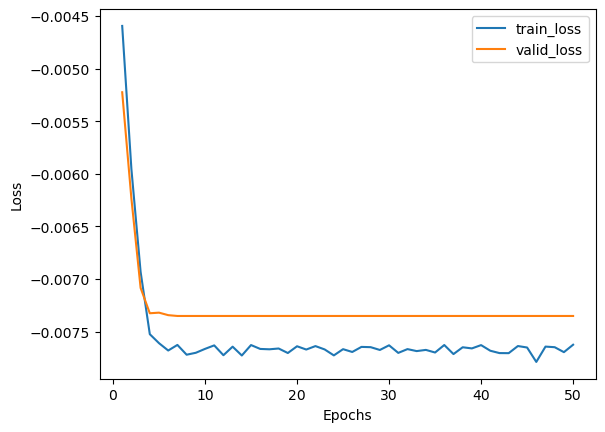

In [17]:
from matplotlib import pyplot as plt
epochs = range(1, len(loss_hist_train) + 1)
plt.plot(epochs, loss_hist_train, label='train_loss')
plt.plot(epochs, loss_hist_valid, label='valid_loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show 

number of samples: 4
tensor([[1.0305, 1.0287, 1.0329,  ..., 1.0310, 1.0345, 1.0345],
        [0.7100, 0.6901, 0.6818,  ..., 0.7414, 0.7423, 0.7418],
        [0.5872, 0.6061, 0.5825,  ..., 0.7331, 0.7615, 0.7159],
        ...,
        [1.0066, 1.0088, 1.0102,  ..., 1.0703, 1.0666, 1.0694],
        [0.8686, 0.8483, 0.8551,  ..., 0.9509, 0.9626, 0.9534],
        [0.9407, 0.9418, 0.9577,  ..., 1.1167, 1.1015, 1.1206]])


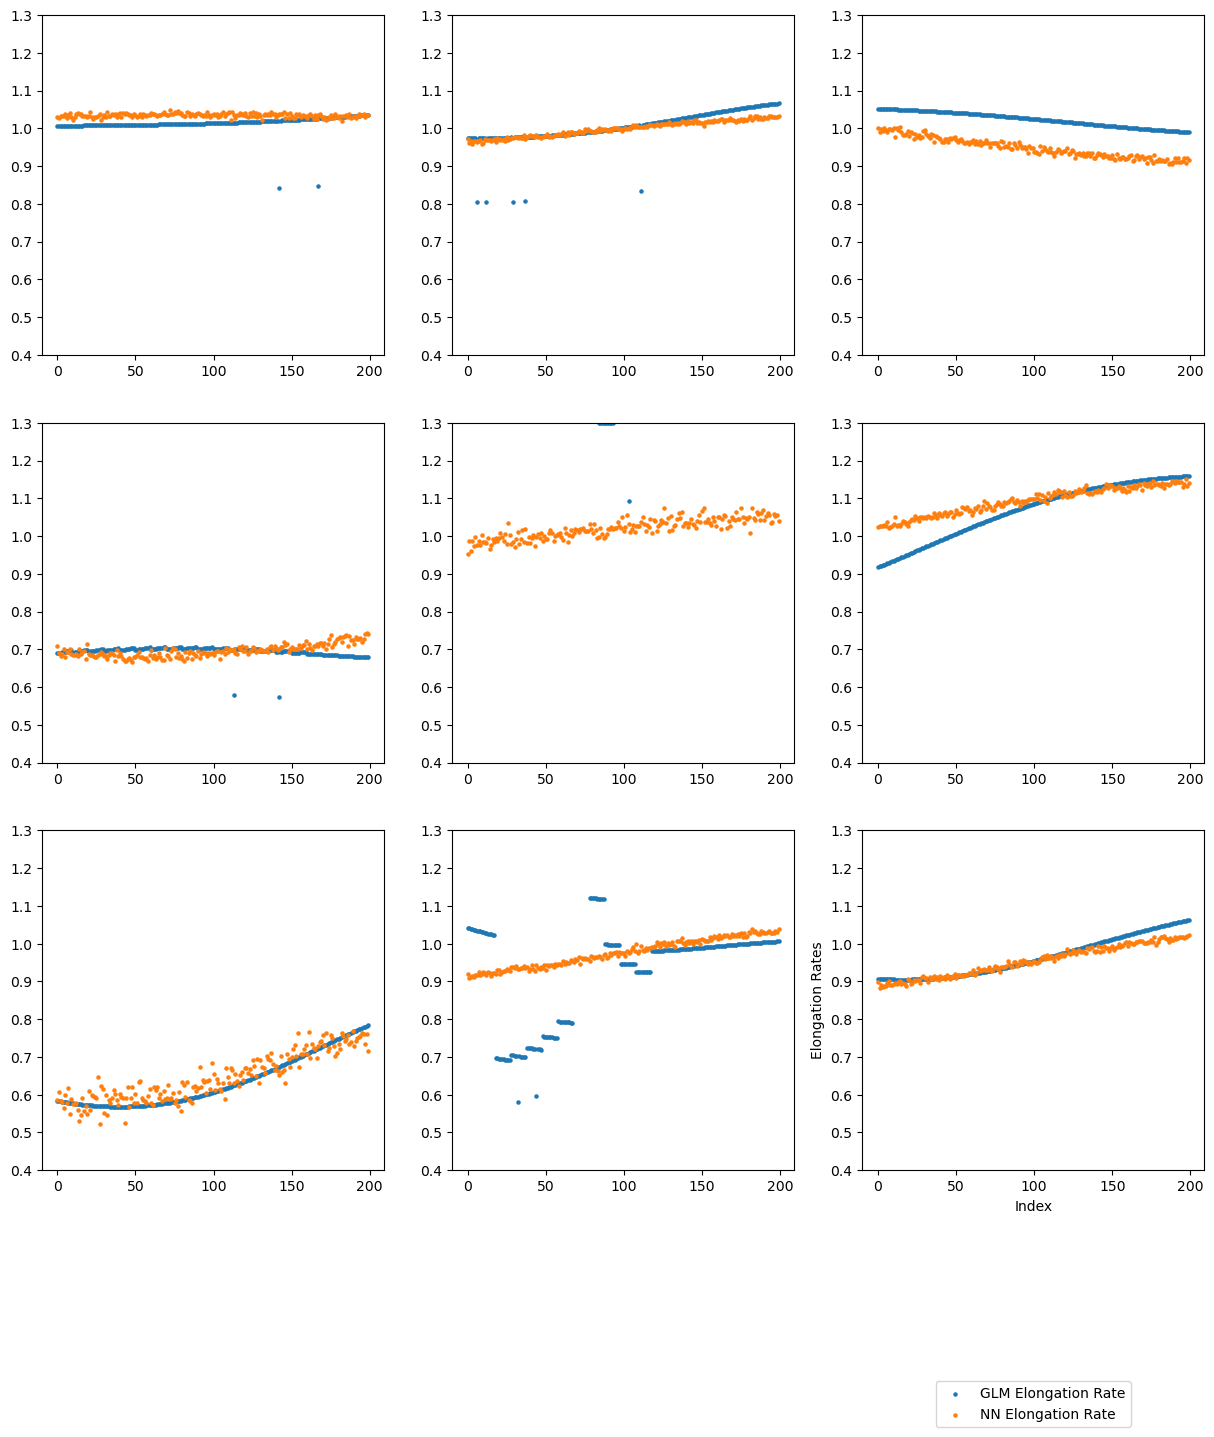

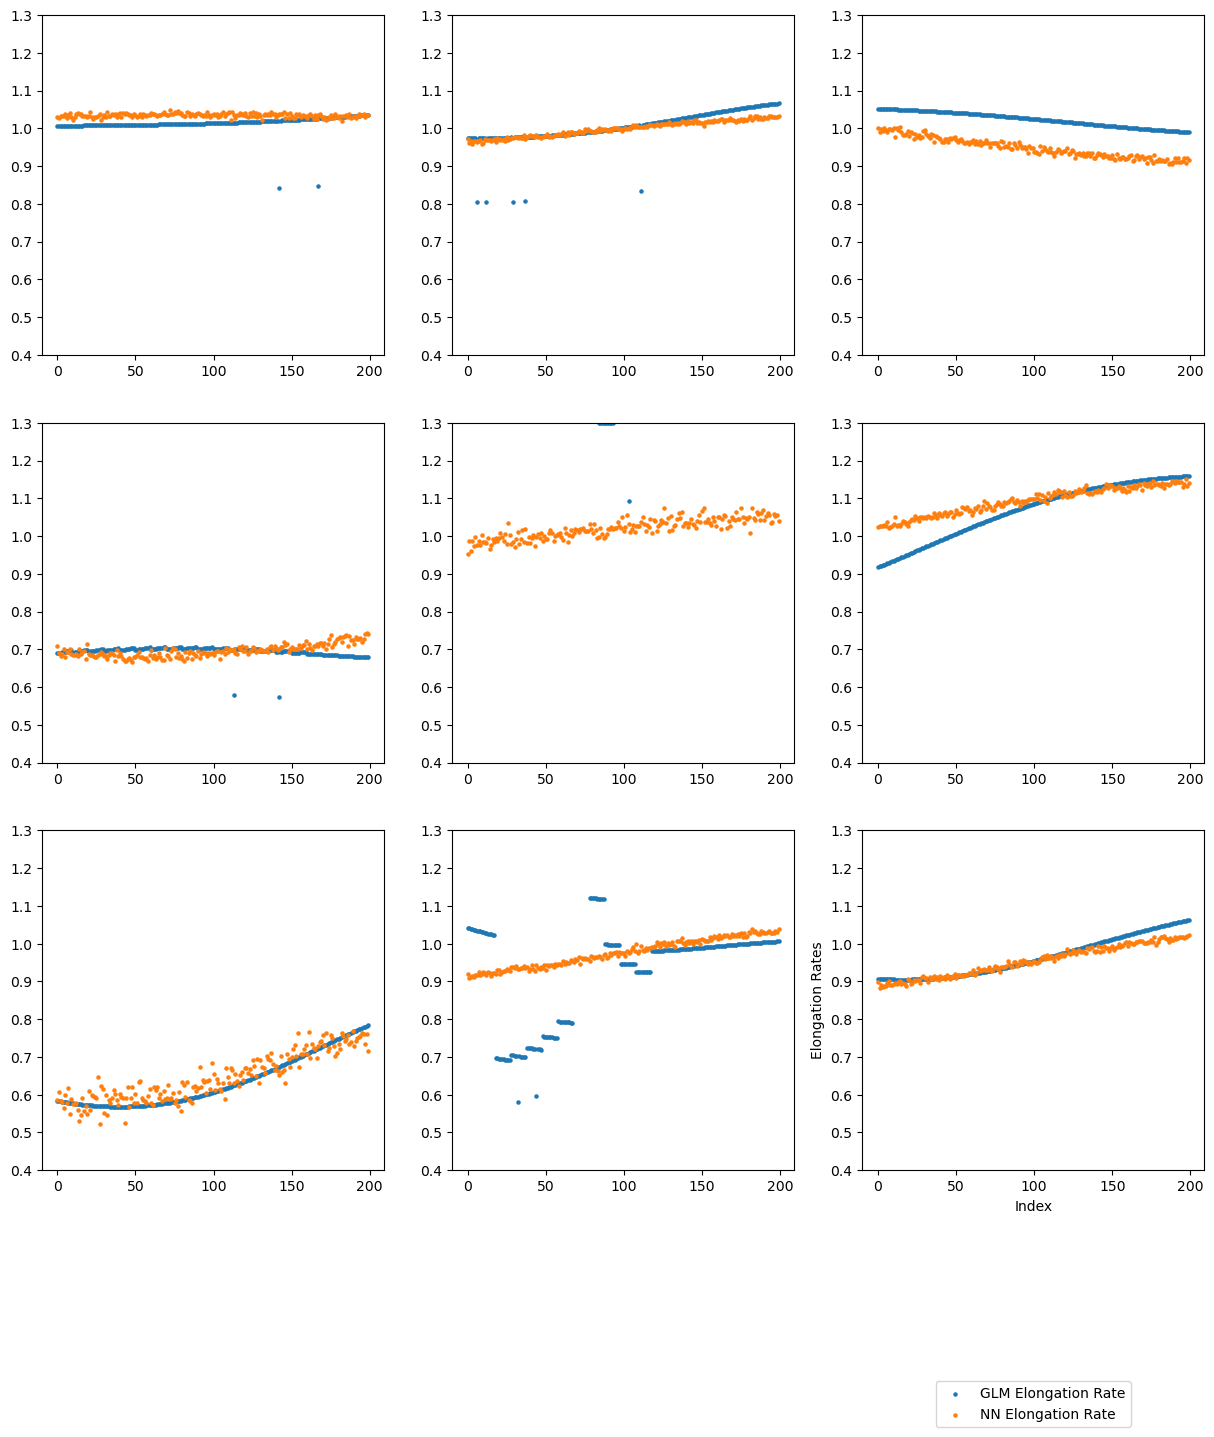

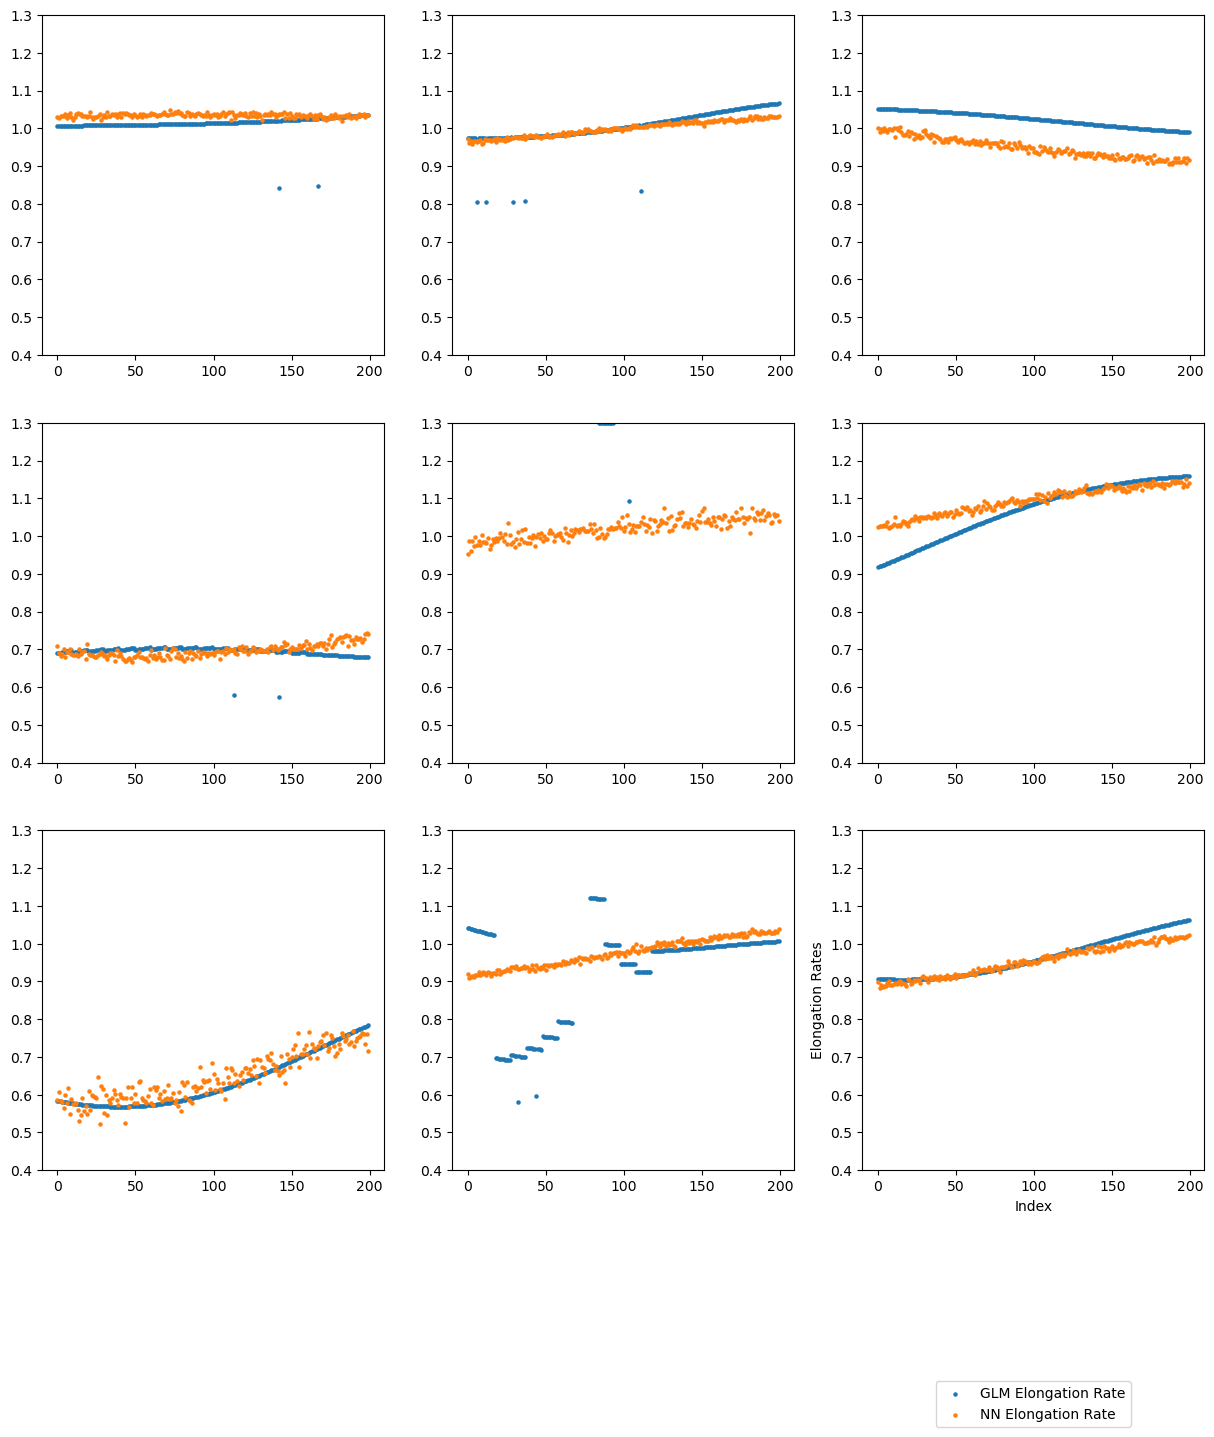

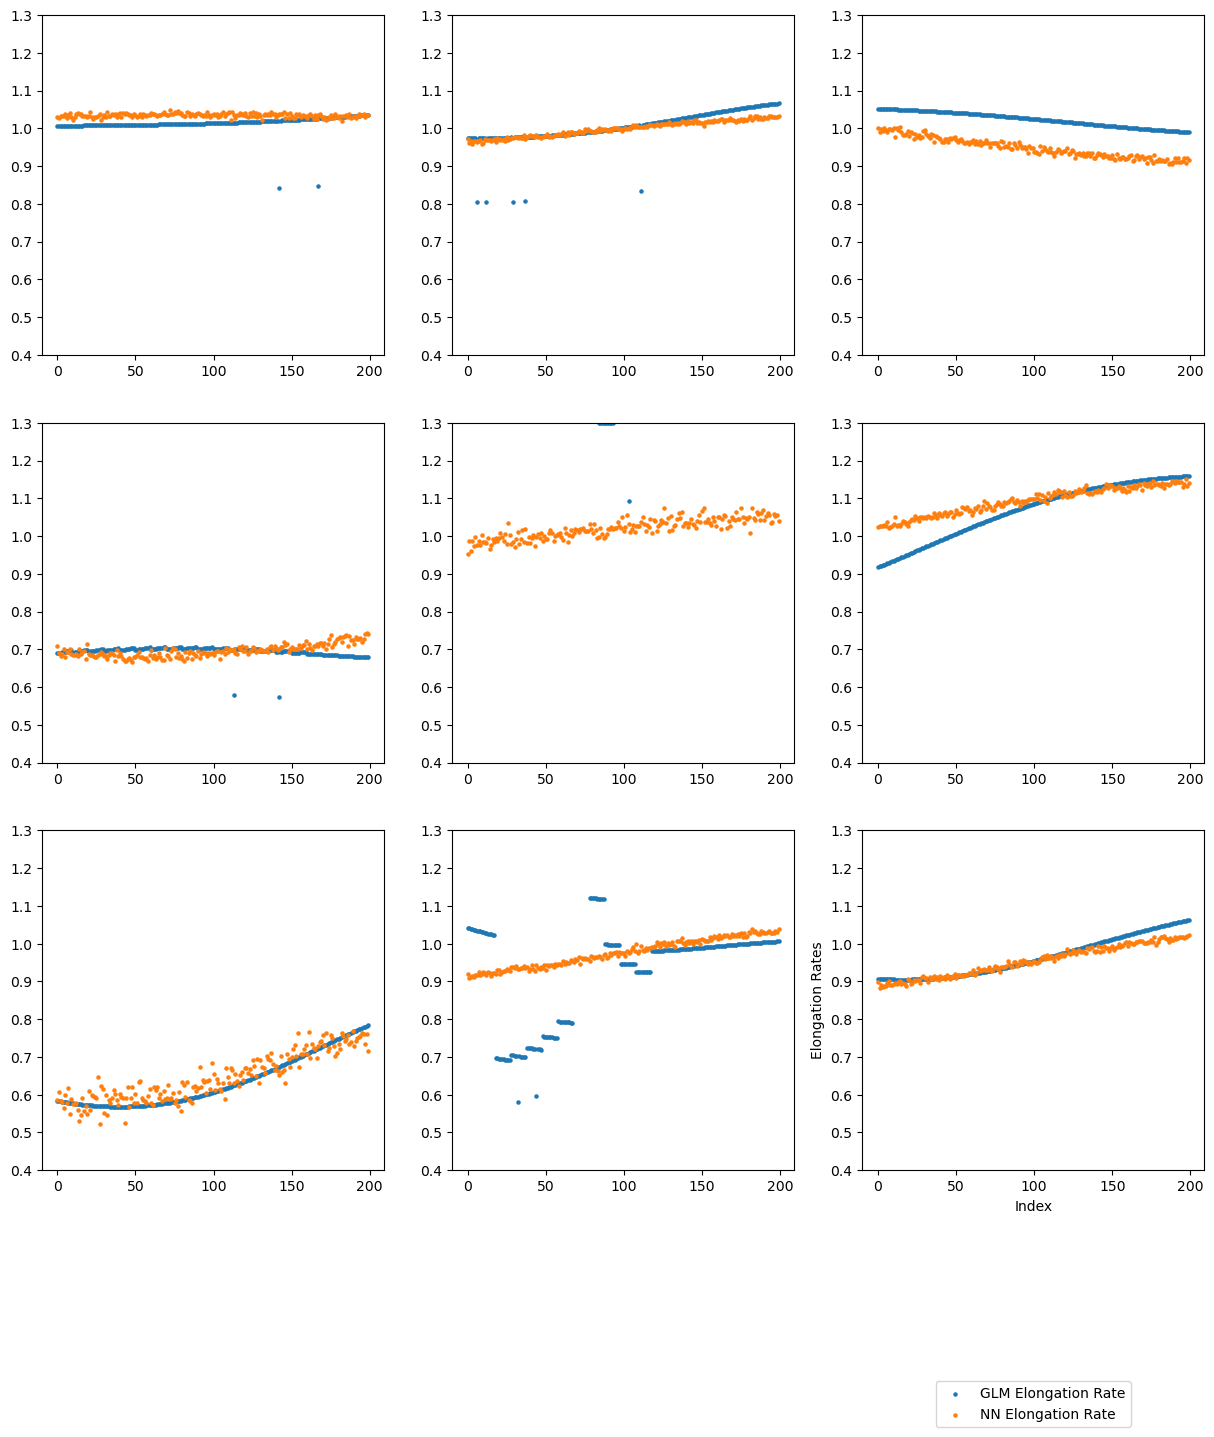

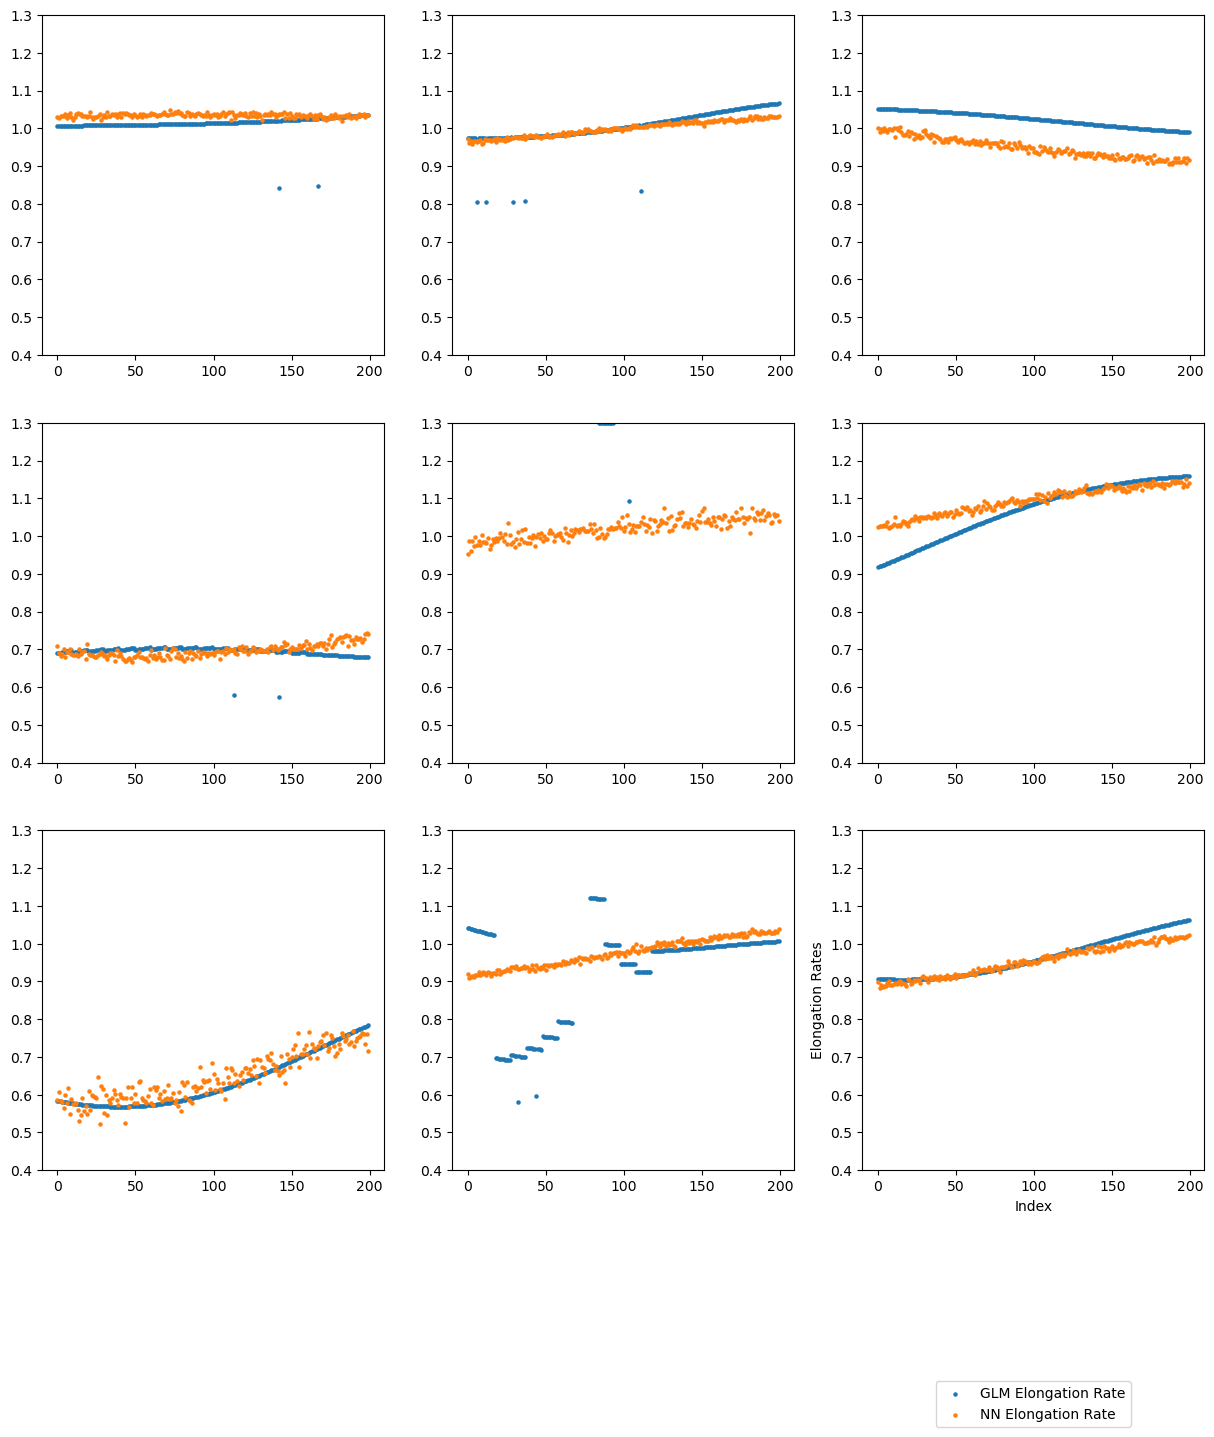

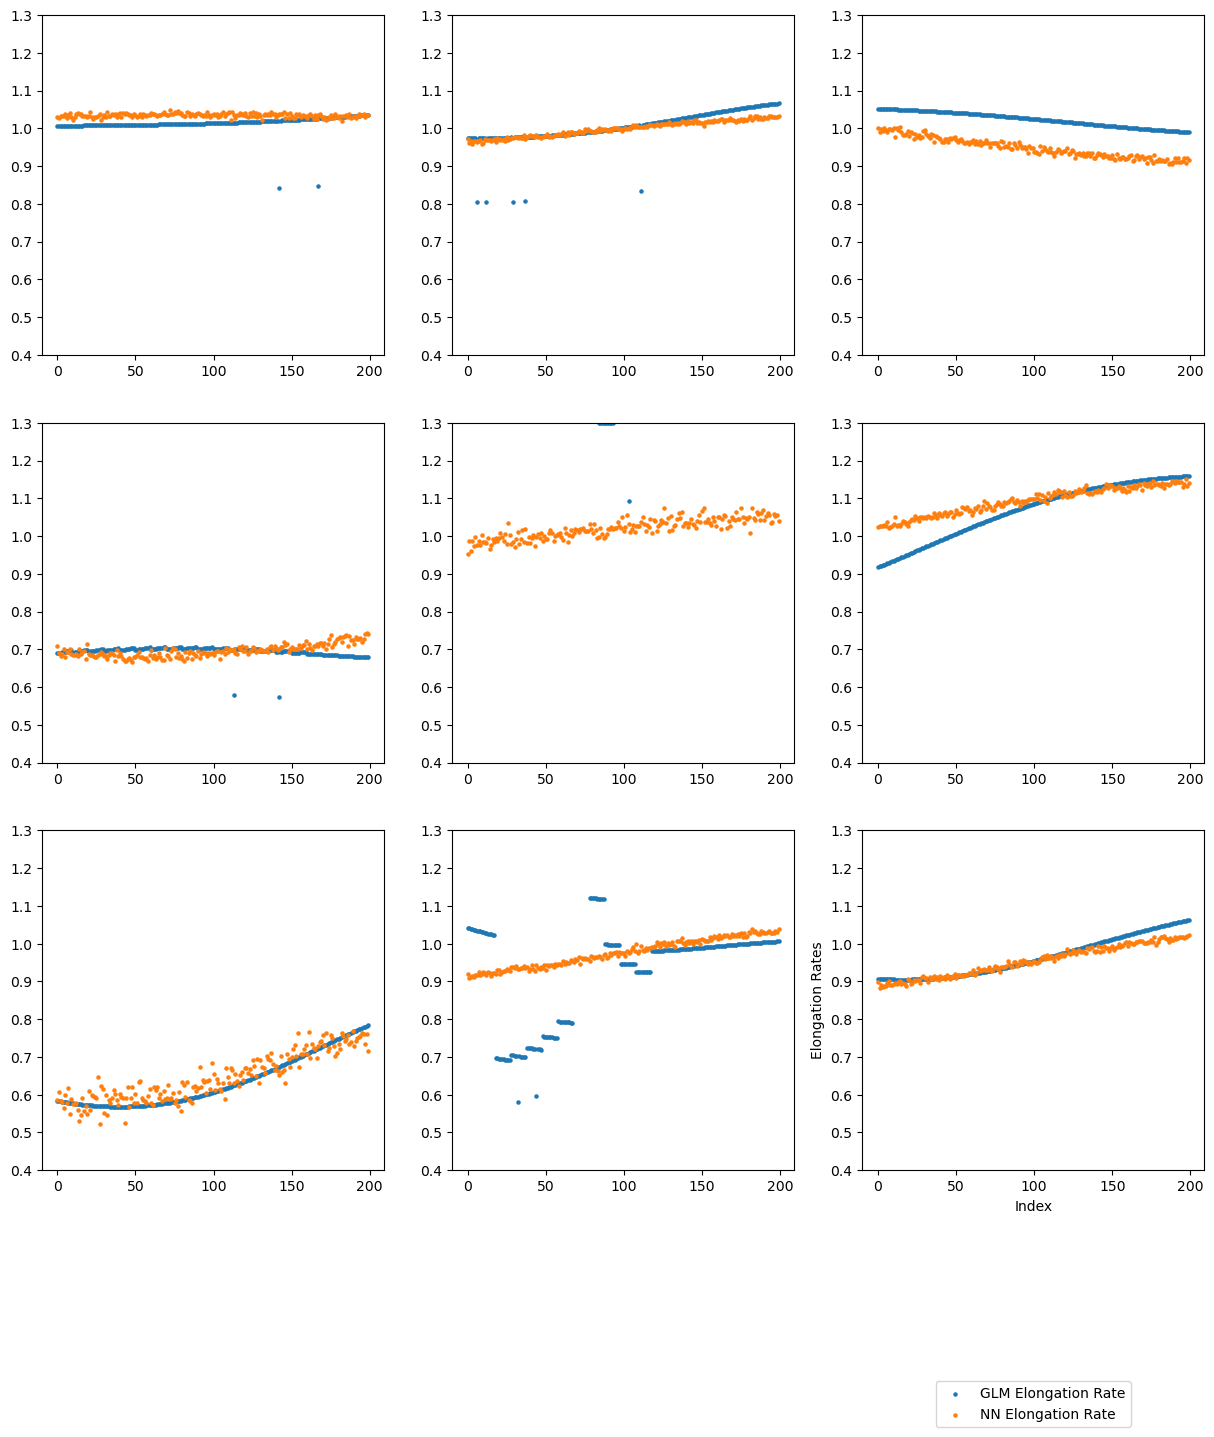

In [110]:
model.eval()

inputs = next(iter(tstdl)) 
print("number of samples: " + str(len(inputs)))

with torch.no_grad():
    outputs = model(inputs['Y_ji'])
    
outputs = torch.exp(outputs)
    
print(outputs)

targets = inputs['Z_ji']

for batch in tstdl:
    targets = inputs['Z_ji']
    outputs = model(inputs['Y_ji'])
    outputs = torch.exp(outputs)
    
    plot_data(targets, outputs)

In [94]:
print(targets.shape)
print(outputs.shape)
print(targets)

torch.Size([64, 200])
torch.Size([64, 200])
tensor([[1.0066, 1.0067, 1.0067,  ..., 1.0355, 1.0358, 1.0361],
        [0.6892, 0.6901, 0.6909,  ..., 0.6786, 0.6785, 0.6783],
        [0.5834, 0.5827, 0.5820,  ..., 0.7802, 0.7819, 0.7837],
        ...,
        [0.9327, 0.9337, 0.9895,  ..., 1.0564, 1.0563, 1.0563],
        [0.8588, 0.8593, 0.8599,  ..., 0.9242, 0.9242, 0.9242],
        [0.9238, 0.9254, 0.9270,  ..., 1.0458, 1.0453, 1.0448]])


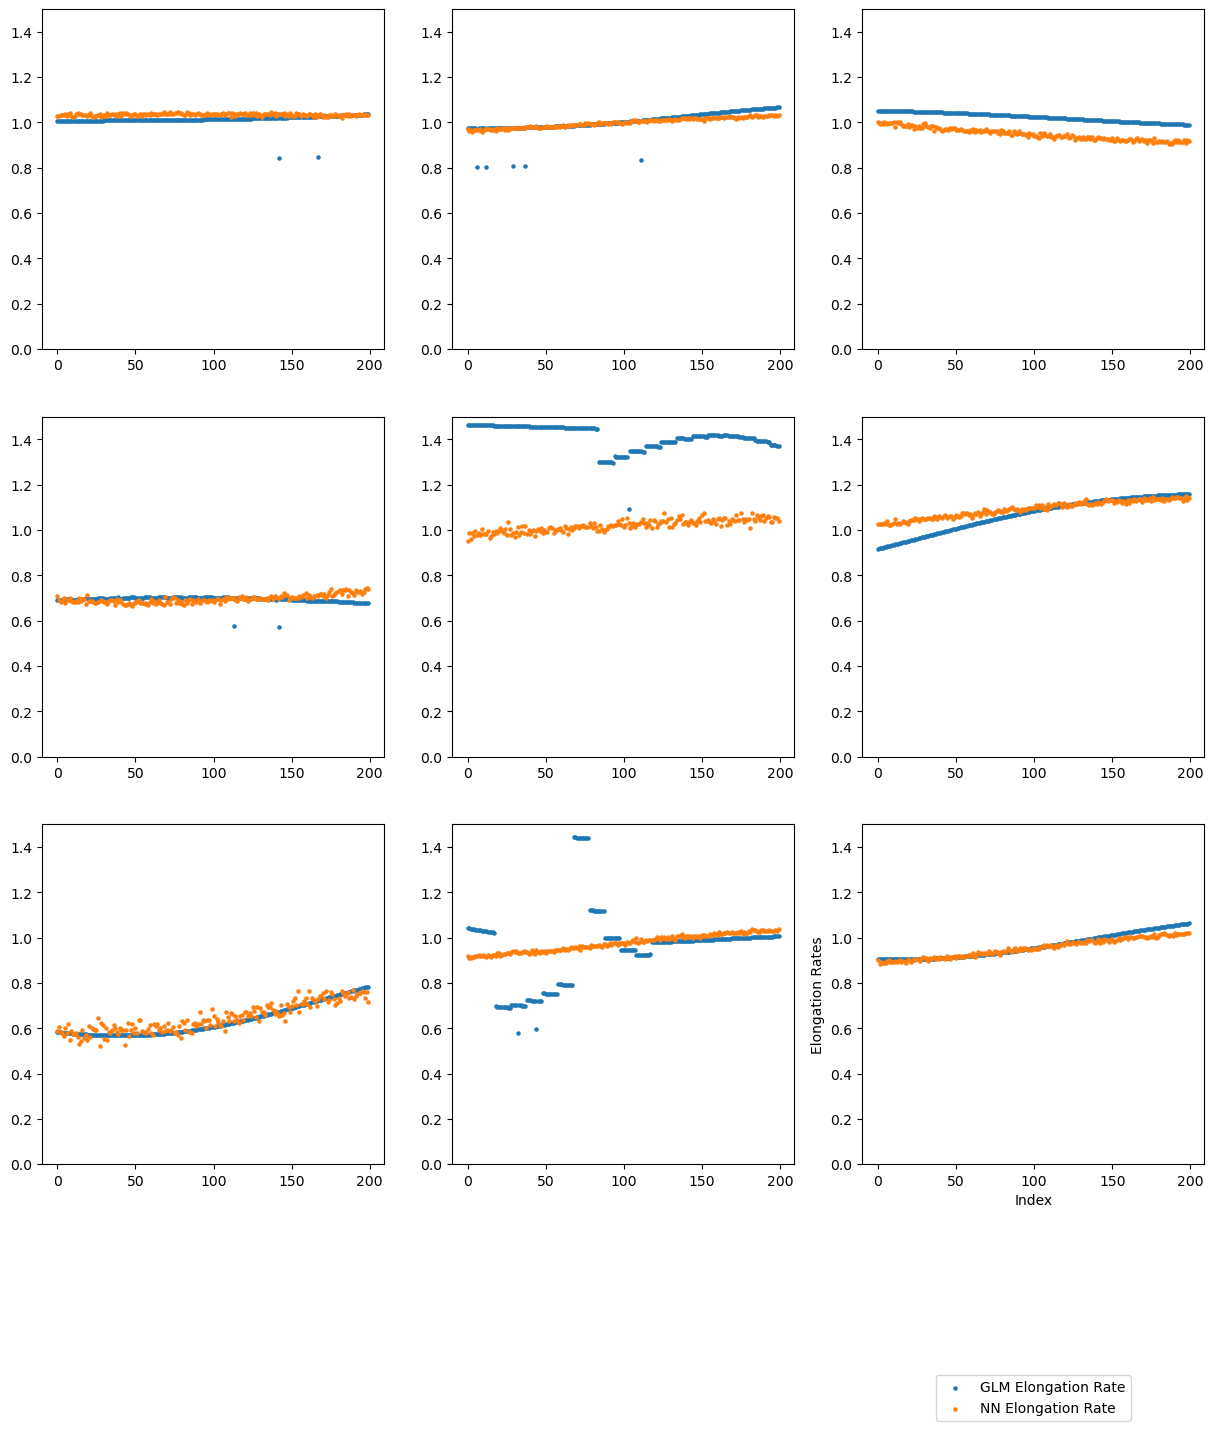

In [112]:
indices = range(len(targets[0]))

fig, axs = plt.subplots(3, 3, figsize=(15,15))
for i in range(3):
    for j in range(3):
        axs[i, j].scatter(indices, targets[i+j*3], s=5)
        axs[i, j].scatter(indices, outputs.detach().numpy()[i+j*3], s=5)
        axs[i, j].set_ylim(0, 1.5)

plt.xlabel('Index')
plt.ylabel('Elongation Rates')
plt.legend(['GLM Elongation Rate', 'NN Elongation Rate'], loc='upper center', bbox_to_anchor=(0.5, -0.6))